In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
def filter_image(input, filter):
    """
    Return the convolution result: image * kernel.
    Caution: use zero-padding.

    Input- image: H x W
           filter: h x w
    Output- convolve: H x W
    """
    pad_height = filter.shape[0] // 2
    pad_width = filter.shape[0] // 2

    padded_image = np.pad(filter, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    output = np.copy(input)
    filter_shape = filter.shape
    half_filter = filter_shape[0] // 2
    for i in range(half_filter, padded_image.shape[0] - half_filter):
        for j in range(half_filter, padded_image.shape[1] - half_filter):
            output[i, j] = input[i-half_filter:i+half_filter+1, j-half_filter:j+half_filter+1].flatten().dot(filter.flatten())
    return output


In [ ]:
def sobel_operator(image):
    """
    Return Gx, Gy, and the gradient magnitude.

    Input- image: H x W
    Output- Gx, Gy, grad_magnitude: H x W
    """
    # TODO: Use filter_image() to complete the function
    Gx, Gy, grad_magnitude = None, None, None
    gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Gx = filter_image(image, gx)
    Gy = filter_image(image, gy)

    grad_magnitude = np.sqrt(Gx**2 + Gy**2)

    return Gx, Gy, grad_magnitude/grad_magnitude.max()

In [ ]:
def generate_gaussian(sigma):
    """
    Return kernel of appropriate size
    Caution: coefficients must sum to 1

    Input- sigma: scalar (should be positive but it will be squared anyway)
    Output- kernel: W x W (no need to return W)
    """
    import seaborn as sns
    size = (6 * int(sigma)) + 1
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    one_d_gauss = lambda x: 1/(2*np.pi*sigma**2) * np.exp(-x**2/(2*sigma**2))

    kernel = one_d_gauss(x) * one_d_gauss(y)
    kernel /= kernel.sum()
    sns.heatmap(kernel, cmap='gray')
    plt.show()
    return kernel

In [ ]:
def harris_detector(image, window_size=5):
    """
    Given an input image, calculate the Harris Detector score for all pixels
    Use zero-padding to handle boundaries

    Input- image: H x W
    Output- results: a image of size H x W
    """
    # compute the derivatives
    Ix, Iy, _ = sobel_operator(image)

    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy
    indexes = list()
    scaling_param = 0.06
    ######################### for tqdm #######################################
    for i in range(window_size // 2, image.shape[0] - window_size // 2):
        for j in range(window_size // 2, image.shape[1] - window_size // 2):
          indexes.append((i, j))
    ######################### for tqdm #######################################
    response = np.zeros_like(image)
    for idx in tqdm(range(len(indexes)), desc="Calculating Harris Response"):
        i, j = indexes[idx]
        # For each image location, construct the structure tensor and calculate
        # the Harris response
        i_xx = Ixx[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1].sum()
        i_xy = Ixy[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1].sum()
        i_yy = Iyy[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1].sum()
        moment_matrix = np.array([[i_xx, i_xy], [i_xy, i_yy]])
        R = np.linalg.det(moment_matrix) - scaling_param * (np.trace(moment_matrix) ** 2)
        response[i, j] = R


    return response

In [ ]:
def nms(input, thresholded_pixels):
    """
    Non-max suppression in 3x3 windows.
    Use zero-padding.

    Input- image: H x W
    Output- nms_image: H x W
    """
    nms_image = np.zeros_like(input)
    M, N = nms_image.shape
    for i, j in tqdm(thresholded_pixels, desc="Applying NMS"):
      # select window based on location of current pixels, look out for index errors
      curr_corner = input[i, j]
      for n in [(0, 1), (1, 0), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, 1), (1, -1)]:
        n_i, n_j = i + n[0], j + n[1]
        if n_i < 0 or n_j >= M or n_j < 0 or n_j >= N:
          continue
        if curr_corner < input[n_i, n_j]:
          break
      nms_image[i, j] = curr_corner
    return nms_image


In [ ]:
def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # extract corners from imshow
    corners = kwargs.pop('corners', None)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')

    # display corners if avaliable
    if corners is not None:
      plt.scatter(corners[:, 1], corners[:, 0])

    # Make sure it outputs
    plt.show()

In [ ]:
def threshold_corners(harris_resp, **kwargs):
  threshold = kwargs.get('threshold', 1000)
  x, y = np.where(harris_resp > threshold)
  return np.stack([x, y], axis=1)

In [ ]:
def plot_gradient_directions(H, W, Gx, Gy):
  XX, YY = np.meshgrid(np.arange(H, step=10), np.arange(W, step=10)) # skip gradients to make it more visible
  Gx, Gy = Gx[XX, YY], Gy[XX, YY]
  plt.quiver(XX, YY, Gx, Gy, angles='xy')
  plt.show()

In [ ]:
min_max_normalization = lambda x: (x - x.min()) / (x.max() - x.min())

def main(image="stevens.jpg", threshold=1000):
  # from google.colab import drive
  #drive.mount('/content/gdrive', force_remount=True)
  #rootpath = '/content/gdrive/MyDrive/cs558_resources/6.869_python_tutorial/6.869_python_tutorial'
  input_image = cv2.imread(image)
  input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
  imshow(input_image)

  # Step 1
  # Sobel filter
  Gx, Gy, grad_mag  = sobel_operator(input_image)
  print('Absolute values of the response to the horizontal and vertical Sobel filters', grad_mag.shape)
  # display
  imshow(Gx)
  imshow(Gy)
  grad_direction = np.arctan2(Gy, Gx).astype(np.float32) * (180)/np.pi
  print('Gradient direction')
  plot_gradient_directions(input_image.shape[0], input_image.shape[1], Gx, Gy)


  # Step 2
  # Gaussian filter
  sigma = 4.0
  kernel = generate_gaussian(sigma)
  print('Kernel for sigma = ' + repr(sigma))
  image_gauss = filter_image(input_image, kernel)
  print('Image after Gaussian filtering')
  # display
  imshow(image_gauss)

  # pad the input image for display purposes.
  padding_kernel = np.zeros_like(kernel)
  padding_kernel[kernel.shape[0]//2, kernel.shape[1]//2] = 1
  input_image = filter_image(input_image, padding_kernel)



  # # Step 3
  # smooth and compute derivatives
  print('Edge gradient magnitude after Gaussian filtering')
  # display only final output - we have already seen intermediate results
  _, _, smooth_grad_image = sobel_operator(image_gauss)
  smooth_grad_image = smooth_grad_image.astype(np.float32)
  imshow(smooth_grad_image)

  # Step 4
  # Harris operator
  winsize = 5
  harris_resp = harris_detector(smooth_grad_image, winsize)
  print('Magnitude of Harris operator')
  # display only final output - we have already seen intermediate results
  imshow(min_max_normalization(harris_resp))

  all_corner_pixels = threshold_corners(harris_resp, threshold=0)
  imshow(input_image, corners=all_corner_pixels)


  # # Step 5
  # # NMS
  thresholded_corner_pixels = threshold_corners(harris_resp, threshold=threshold)
  image_nms = nms(harris_resp, thresholded_pixels=thresholded_corner_pixels)
  print('\nMagnitude of Harris operator after NMS')
  # display only final output - we have already seen intermediate results
  # Thresholding and super-imposing corners on input
  # You may implement this here or as separate function(s)
  print('Corner locations after thresholding')
  # display
  imshow(min_max_normalization(image_nms))
  print('Corners superimposed on input image')
  # display
  imshow(input_image, corners=thresholded_corner_pixels)


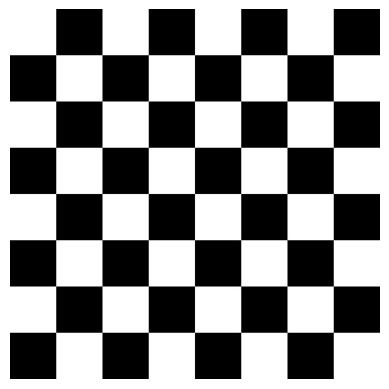

Absolute values of the response to the horizontal and vertical Sobel filters (600, 600)


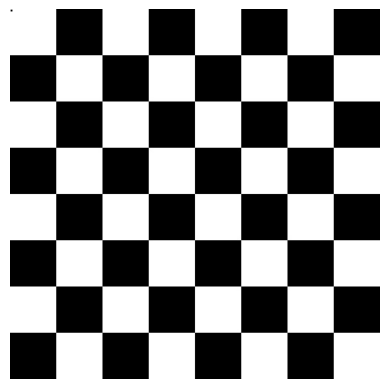

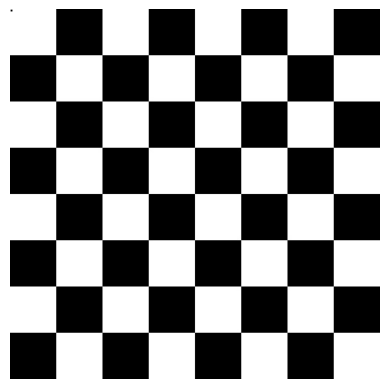

Gradient direction


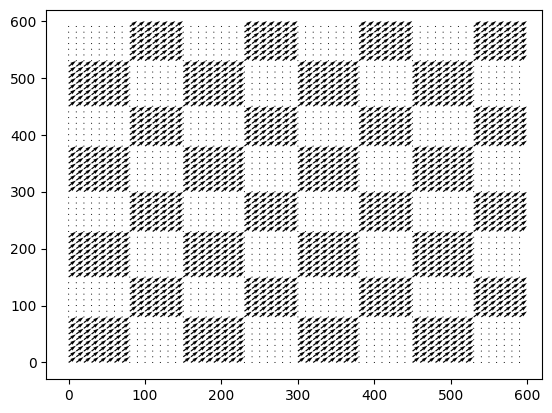

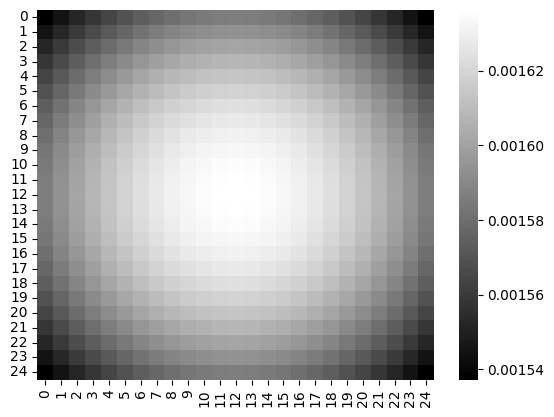

Kernel for sigma = 4.0
Image after Gaussian filtering


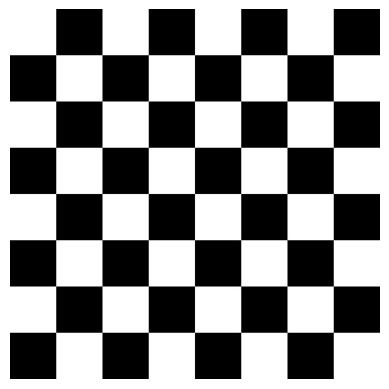

Edge gradient magnitude after Gaussian filtering


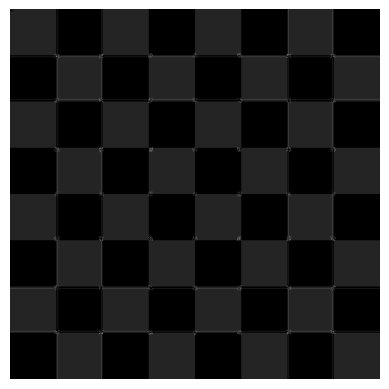

Calculating Harris Response: 100%|██████████| 355216/355216 [00:14<00:00, 24576.02it/s]


Magnitude of Harris operator


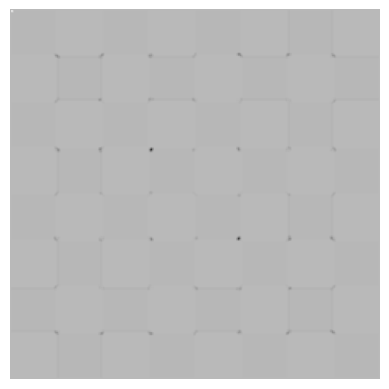

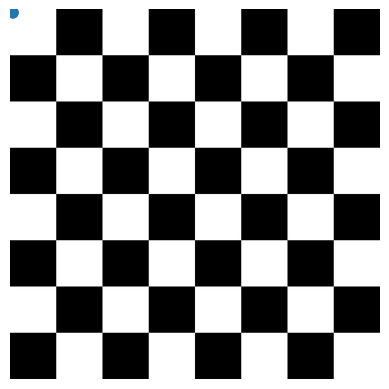

Applying NMS: 0it [00:00, ?it/s]
<ipython-input-36-69ec53e8a050>:1: RuntimeWarning: invalid value encountered in divide
  min_max_normalization = lambda x: (x - x.min()) / (x.max() - x.min())
/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)



Magnitude of Harris operator after NMS
Corner locations after thresholding


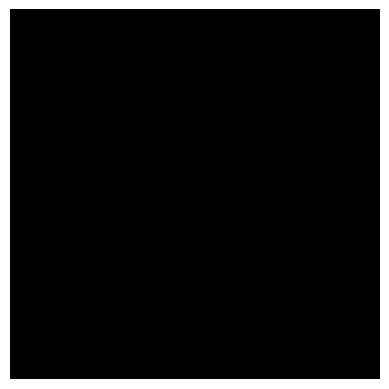

Corners superimposed on input image


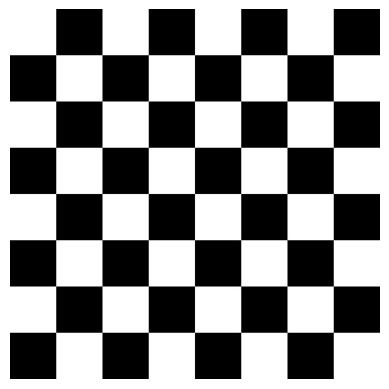

In [ ]:
main(image="cb.jpg", threshold=1000)

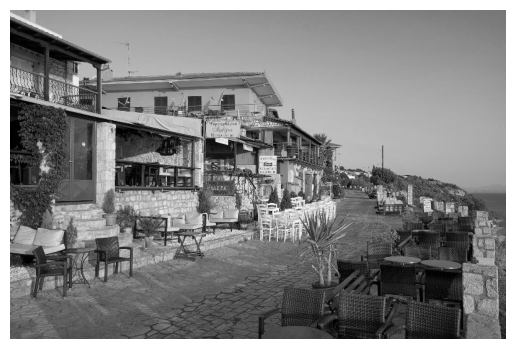

Absolute values of the response to the horizontal and vertical Sobel filters (533, 802)


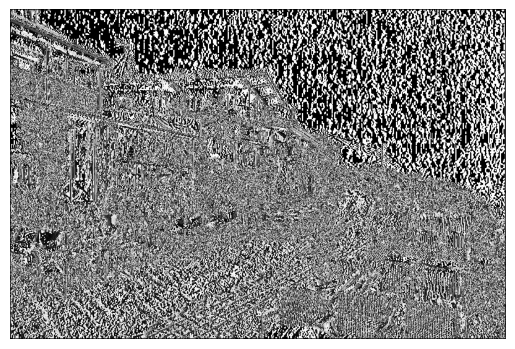

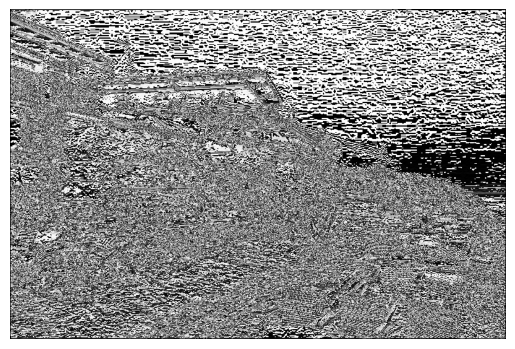

Gradient direction


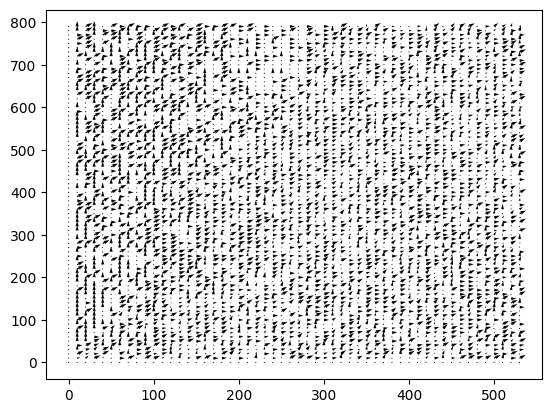

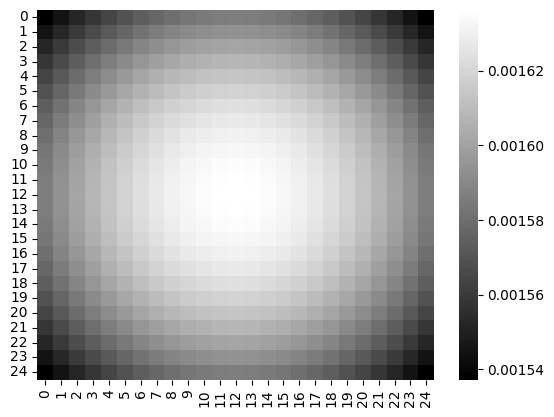

Kernel for sigma = 4.0
Image after Gaussian filtering


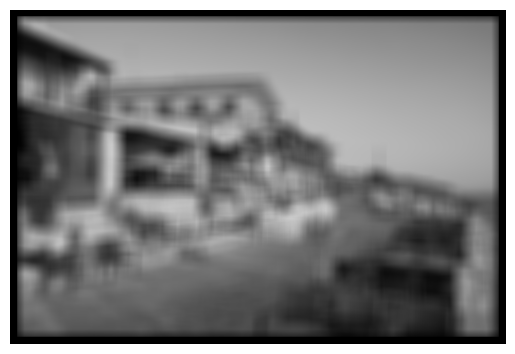

Edge gradient magnitude after Gaussian filtering


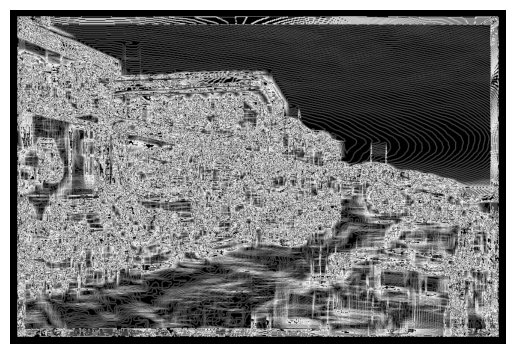

Calculating Harris Response: 100%|██████████| 454566/454566 [00:19<00:00, 22869.35it/s]


Magnitude of Harris operator


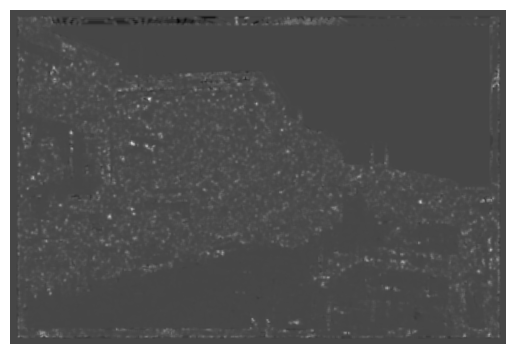

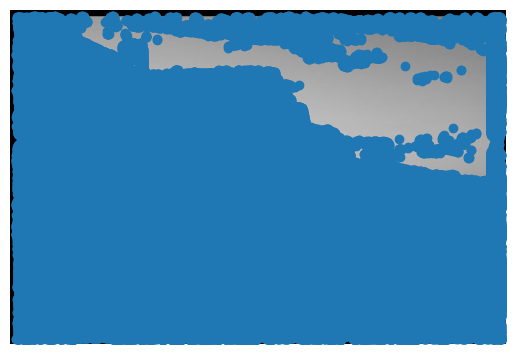

Applying NMS: 100%|██████████| 1413/1413 [00:00<00:00, 114088.43it/s]



Magnitude of Harris operator after NMS
Corner locations after thresholding


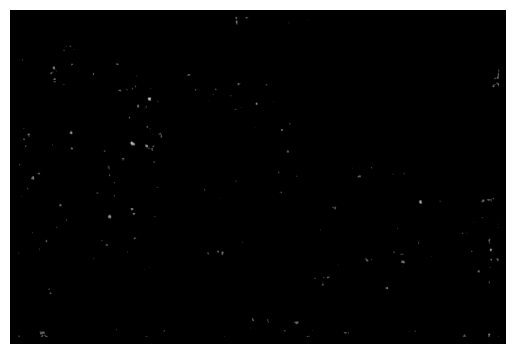

Corners superimposed on input image


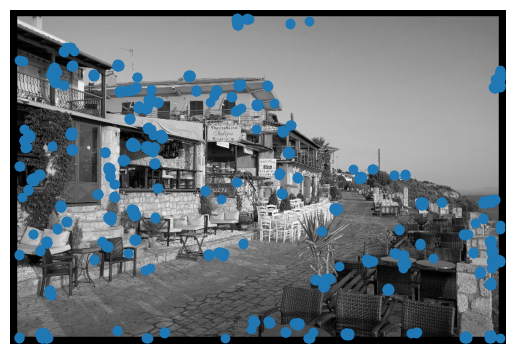

In [ ]:
main(image="village3.jpg", threshold=2000)

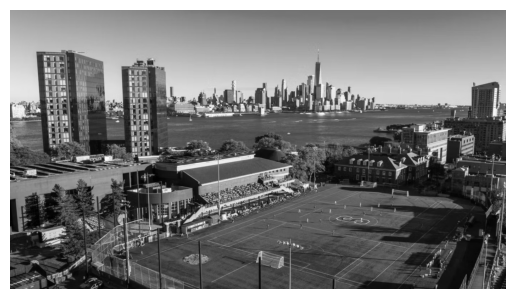

Absolute values of the response to the horizontal and vertical Sobel filters (828, 1471)


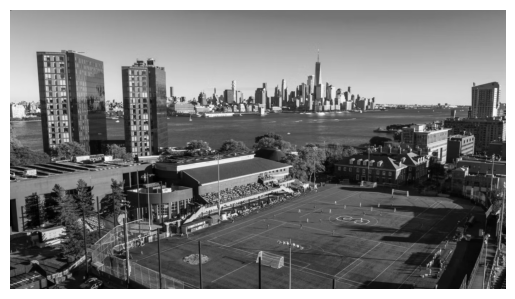

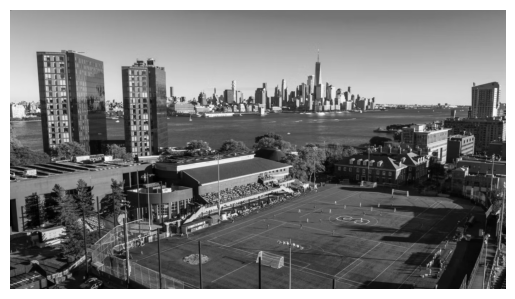

Gradient direction


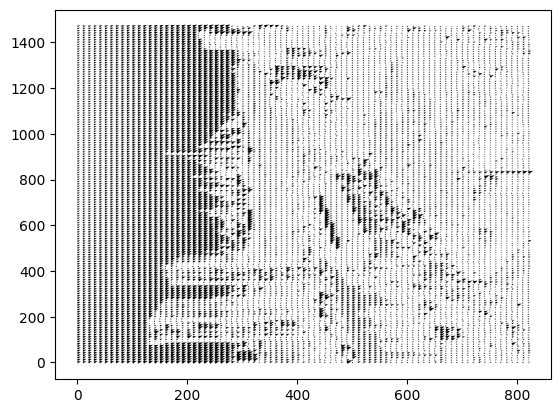

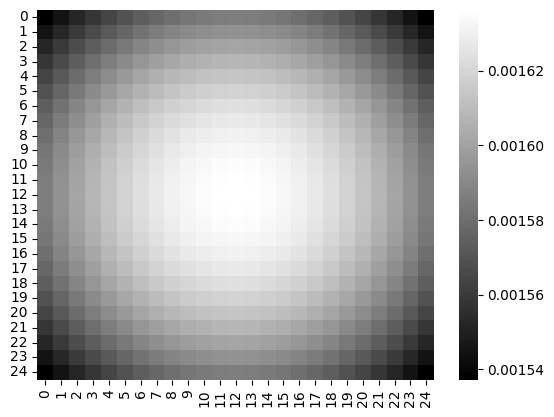

Kernel for sigma = 4.0
Image after Gaussian filtering


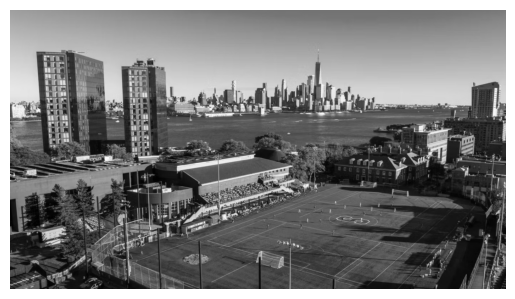

Edge gradient magnitude after Gaussian filtering


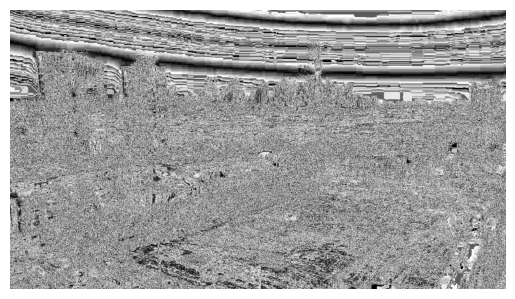

Calculating Harris Response: 100%|██████████| 1208808/1208808 [00:51<00:00, 23473.19it/s]


Magnitude of Harris operator


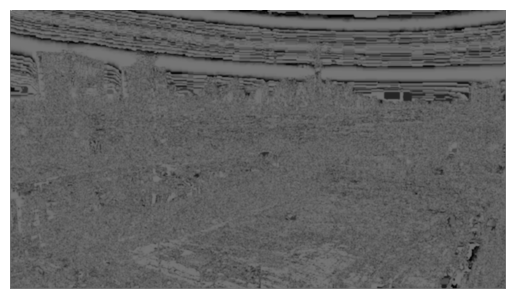

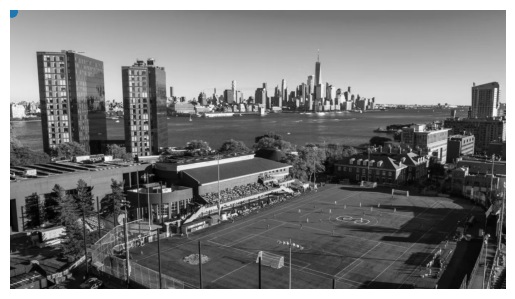

Applying NMS: 0it [00:00, ?it/s]
<ipython-input-36-69ec53e8a050>:1: RuntimeWarning: invalid value encountered in divide
  min_max_normalization = lambda x: (x - x.min()) / (x.max() - x.min())



Magnitude of Harris operator after NMS
Corner locations after thresholding


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


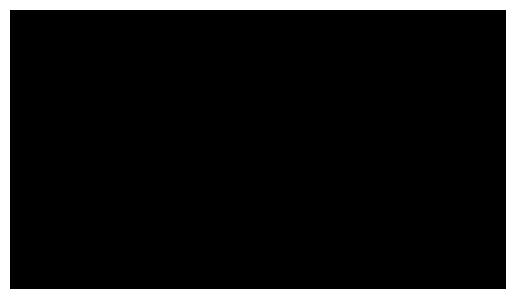

Corners superimposed on input image


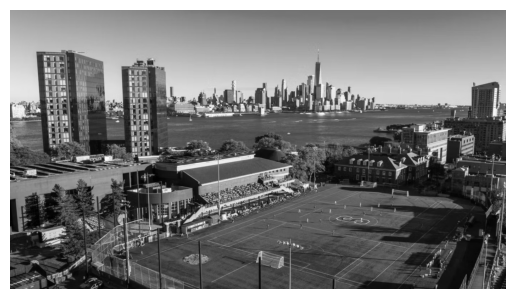

In [ ]:
main(image="stevens.jpg", threshold=3000)